In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Cleaning the data

First step of cleaning the data is to inspect the data. We deduce the following based on inspecting the data from first glance

- Firstfile: A record of sales over a period of 2015-2016 per individual with given max retail price (MRP), discount value and final price.
- Media Investment: For each month, how much investment (in 10M units) was put into the platform for marketing as a whole divided by different categories of investment (e.g digital marketing, sponsorship, TV marketing etc)
- NPSScore: For each month, what is the average NPS score? Unknown which customers are surveyed on NPS and methodology of survey.
- Product List: A tally of the total sales grouped per product vertical. More of a pivot table to double check, but we can ignore this for our analysis. 
- Sales: A corrupted file that would probably have another version of sales, but needs further processing. When cleaned, it reveals itself as similar to the firstfile, except containing extra information about procurement and delivery times. 
- Secondfile: Seems to contain the raw values of the media investment, as the spending numbers are non normalized. 
- SpecialSale: List of dates in which special promotions occurred. These dates are already put in firstfile, so we will ignore these

First, we clean up the corrupted Sales file. 

In [ ]:
def clean_sales_file(old_path,new_path):
    with open(old_path) as f:
        salesfile = f.read()
    #Problem might be comma in which pandas does not know how to parse correctly
    salesfile = salesfile.replace('\t',',')
    
    with open(new_path,'w+') as f:
        f.write(salesfile)  

clean_sales_file('../causal_inf_project/Sales.csv','../causal_inf_project/Sales_rewrite.csv')

In [2]:
firstfile = pd.read_csv('../causal_inf_project/firstfile.csv')
mediainvestment = pd.read_csv('../causal_inf_project/MediaInvestment.csv')
npsscore = pd.read_csv('../causal_inf_project/MonthlyNPSScore.csv')
productlist = pd.read_csv('../causal_inf_project/ProductList.csv')
sales_cleaned = pd.read_csv('../causal_inf_project/Sales_rewrite.csv')
secondfile = pd.read_csv('../causal_inf_project/Secondfile.csv')
specialsale = pd.read_csv('../causal_inf_project/SpecialSale.csv')

We decide to clean the files a bit more and engineer a few more features. We will only clean up the files that are of interest. We have explored all files and verified that they will not contribute much to the business analysis. 

For marketing spend, we will clean the data a bit more. We want to aggregate some of the spending categories into smaller ones as there are quite a lot of overlap that can make analysis too large.

In [3]:
def clean_firstfile(df):
    # Function to clean up first file.
    
    # Check that either no promotion or sales name is present
    if pd.isnull(df.Sales_name).sum()>0:
        assert ValueError('Null sales')
    
    if df[df.gmv_new<=0].units.count()>0:
        assert ValueError('Invalid GMV')

    df['Date'] = pd.to_datetime(df.Date)
    df['MonthStart'] = df['Date'] - pd.to_timedelta(df['Date'].dt.day - 1,'D')

    df['price_check']  = df.discount+df.gmv_new

    # We'll do a discount sanity check, but overall, it's not big difference because of a floating point error. 
    discount_sanity_check = firstfile[firstfile['price_check'] !=firstfile.product_mrp].units.count()
    print(f"Bad rows:{discount_sanity_check}")
    
    return df

def clean_sales(df):
    # Function to clean up the sales file.     
    try:
        df['GMV'].astype(int)
    except:
        print('Unable to convert to int, investigate')

    # Sales cleaned turned out to have a empty string issue that we had to replace.
    # It was not large, but it was intefering with conversions
    
    df['new_GMV'] = df['GMV'].replace(' ',0).astype(float)
    df['Date'] = pd.to_datetime(df.Date)
    
    # We also observe a weird issue where new GMV has negative values. Please exclude in final analysis
    
    bad_count = df[df.new_GMV<0].new_GMV.count()
    print(f'Weird GMV values: {bad_count}')

    df['day']=df.Date.dt.floor('D')
    df['MonthStart'] = df['day'] - pd.to_timedelta(df['day'].dt.day - 1,'D')

    return df 

def clean_secondfile(df):
    # We're splitting apart the secondfile investment component as it seems to be the raw numbers.
    secondfile_investment = df[['month','Year', 'Month', 'Total.Investment', 'TV', 'Digital', 'Sponsorship',
       'Content.Marketing', 'Online.marketing', 'Affiliates', 'SEM', 'Radio',
       'Other', 'Date']].fillna(0)    
    
    # Normalizing the amounts here. 
    col = ['Total.Investment','TV', 'Digital', 'Sponsorship',
           'Content.Marketing', 'Online.marketing', 'Affiliates', 'SEM', 'Radio','Other']

    secondfile_investment['Date'] = pd.to_datetime(secondfile_investment.Date)
    
    secondfile_investment = pd.concat([(secondfile_investment[col]/10000000),secondfile_investment.Date],axis=1)
    
    secondfile_investment['dig'] = secondfile_investment['Digital'] + secondfile_investment['Online.marketing'] + secondfile_investment['Content.Marketing']+secondfile_investment['SEM']
    secondfile_investment['traditional'] = secondfile_investment['TV'] + secondfile_investment['Radio']
    secondfile_investment['rest'] = secondfile_investment['Other'] + secondfile_investment['traditional'] + secondfile_investment['Affiliates']

    return secondfile_investment

npsscore['Date'] = pd.to_datetime(npsscore.Date)


firstfile = clean_firstfile(firstfile)
sales_cleaned = clean_sales(sales_cleaned)
secondfile_investment = clean_secondfile(secondfile)


Bad rows:106
Unable to convert to int, investigate
Weird GMV values: 0


Now that we have cleaned our data rows. We highlight a few important findings. 

- We are not able to identify repeat customers. There is no ID that allows us to do this join, and therefore, we will assume each order belongs to a new customer.
- We will limit our data analysis from Oct 2015 to April 2016. This is because it feels as though there is missing data from pre September and May 2016 based on the analysis below.


In [17]:
aframe = firstfile.groupby(['Date','product_category','product_subcategory','product_vertical']
                   ).units.count()

bframe = sales_cleaned.rename(columns={'Analytic_Category':'product_category',
                             'Sub_category':'product_subcategory',
                            'product_analytic_vertical':'product_vertical',
                                       'day':'Date',
                                         'Date':'d'
                             }).groupby(
    ['Date','product_category','product_subcategory','product_vertical']
                     ).MRP.count(
                     )

olp=pd.concat([aframe,bframe],axis=1).rename(columns={'units':'firstfile','MRP':'sales'
})

olp=olp.fillna(0).reset_index()
olp['differ'] = abs(olp.firstfile-olp.sales)
olp['differ_c'] = (olp.firstfile-olp.sales)

olp['ms'] = olp['Date'] - pd.to_timedelta(olp.Date.dt.day - 1,'D')

olp[olp.differ>2].groupby('ms').Date.count()

ms
2015-07-01    1103
2015-08-01      16
2015-09-01    1466
2015-10-01     500
2015-11-01     457
2015-12-01     395
2016-01-01     378
2016-02-01     334
2016-03-01     401
2016-04-01     614
2016-05-01    1589
2016-06-01    1484
Name: Date, dtype: int64

Above table lists the number of differing entries between the two versions of the sales tables. 

When exploring the distribution of the prices of unit MRP and final sales value. We notice that the tails are incredibly long and there are too many categories. We will use a few methods to try to control it a bit better. First, too many categories.
1. To simulate different product demand and markets, we will attempt to group the categories together by the following rules:
   - For cameras, we assume that each camera type is unique depending on market.
   - For camera accessories, we will assume that they have inelastic demand and therefore can be differentiated by price.
   - For gaming accessories, they seem to have low variance except for gaming headset. Given gaming headset also comprises a large subset of total count, we will need to split this out, but otherwise, gaming accessories can be assumed to be inelastic as well.
   - For gaming consoles, the pricing and variance in the MRP seems to suggest they don't fit anywhere and we should separate them out in new categories.
   - We will exclude membership cards given their small number to the total sales.
   - TVAudioSmall and AudioAcessory seem to be inelastic demand for home entertainment so we will group them together
   - HomeAudio related items will ge grouped together to represent the same demand. (amps, speakers)
   - We will use the product subcategory classifcation for the rest as a default and further transform if needed. 


In [30]:
# To justify that the count of GameMembershipCards is low enough to ignore.

(firstfile[firstfile.product_subcategory=='GameMembershipCards'].groupby('MonthStart').units.count(
))/firstfile.groupby('MonthStart').units.count()

MonthStart
2015-07-01         NaN
2015-08-01         NaN
2015-09-01         NaN
2015-10-01         NaN
2015-11-01         NaN
2015-12-01         NaN
2016-01-01         NaN
2016-02-01    0.000007
2016-03-01    0.000102
2016-04-01    0.000365
2016-05-01    0.000185
2016-06-01    0.000052
Name: units, dtype: float64

In [4]:
tr = firstfile[(firstfile.MonthStart>=pd.Timestamp(2015,10,1))
        &(firstfile.MonthStart<=pd.Timestamp(2016,5,1))
&(firstfile.product_subcategory!='GameMembershipCards')
        ]

In [37]:
# Let's understand the distribution of price here on the whole.

tr.groupby(['product_category','product_subcategory','product_vertical']).product_mrp.aggregate(['mean','std',
                                                                                              'count']).tail(50)

mean  \
product_category   product_subcategory product_vertical                        
CameraAccessory    CameraAccessory     FlashShoeAdapter           390.000000   
                                       Lens                      5325.570991   
                                       ReflectorUmbrella          932.000000   
                                       Softbox                    984.750000   
                                       Strap                     1204.482852   
                                       Teleconverter            20490.000000   
                                       Telescope                 2644.692248   
                   CameraStorage       CameraStorageMemoryCard   2013.129114   
EntertainmentSmall AmplifierReceiver   AmplifierReceiver         2942.126571   
                   AudioAccessory      Microphone                3088.023857   
                                       MicrophoneAccessory        583.079252   
                   AudioMP3Player      AudioMP3Player            2608.486500   
                   HomeAudio           BoomBox                   4134.356855   
                                       DJController             18319.496183   
                                       Dock                      1580.416595   
                                       DockingStation            1899.422642   
                                       FMRadio                   1372.636878   
                                       HiFiSystem                5110.465598   
                                       HomeAudioSpeaker          4688.627266   
                                       KaraokePlayer            14000.000000   
                                       SlingBox                 13331.666667   
                                       SoundMixer               13131.530612   
                                       VoiceRecorder             5346.887534   
                   HomeTheatre         HomeTheatre               9269.999160   
                   Speaker             LaptopSpeaker             1563.650899   
                                       MobileSpeaker             3119.003098   
                                       \N                        9814.354815   
                   TVVideoSmall        RemoteControl              649.746711   
                                       SelectorBox               3862.273228   
                                       VideoGlasses              1053.034241   
                                       VideoPlayer               4194.125578   
GameCDDVD          Game                CodeInTheBoxGame          1496.515632   
                                       PhysicalGame              3122.444886   
GamingHardware     GamingAccessory     CoolingPad                1204.000000   
                                       GameControlMount          3499.000000   
                                       GamePad                   1940.805082   
                                       GamingAccessoryKit        1009.182426   
                                       GamingAdapter             1271.681553   
                                       GamingChargingStation     2209.847826   
                                       GamingHeadset             3003.827748   
                                       GamingKeyboard            2239.205660   
                                       GamingMemoryCard          1257.041915   
                                       GamingMouse               1107.817489   
                                       GamingMousePad            1068.542674   
                                       GamingSpeaker             2497.903061   
                                       JoystickGamingWheel       3019.648526   
                                       MotionController          6335.027888   
                                       TVOutCableAccessory        747.591561   
                   GamingConsole       GamingConsole            29103.30

In [5]:
def recategorize(row):
    if row['product_category'] == 'Camera':
        return 'Camera_'+row['product_vertical']
    elif row['product_category'] == 'CameraAccessory':
        return 'CameraAccessory'
    elif row['product_subcategory'] == 'AudioAccessory' or row['product_subcategory']=='TVVideoSmall':
        return 'SmallAudio'
    elif row['product_vertical'] == 'GamingHeadset':
        return 'GamingHeadset'
    elif row['product_subcategory'] in ('GamingAccessory','Game','Speaker','AudioMP3Player'):
        return row['product_subcategory']  
    elif row['product_subcategory'] == 'GamingConsole':
        return 'GamingConsole_'+row['product_vertical']
    elif row['product_subcategory'] in ('AmplifierReceiver','HomeTheatre','HomeAudio'):
        return 'HomeAudio'

In [6]:
tr['new_cat']=tr.apply(recategorize,axis=1)

One weird thing we notice when plotting out some the count of volume over time is that there are specific dates where the volume jumps massively. We will be attempting to see if we can explain what caused these volumes to jump massively. For now, we label them.

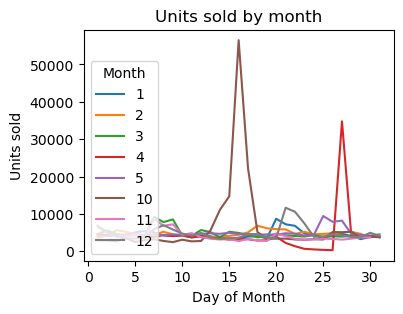

In [21]:
ax = tr.groupby([firstfile.Date.dt.month,firstfile.Date.dt.day]).units.count().unstack(
    level=0).plot(figsize=(4,3),title='Units sold by month')
ax.set_xlabel('Day of Month')
ax.set_ylabel('Units sold')
ax.legend(title='Month',loc=3)

In [ ]:
dates=[pd.Timestamp(2015,10,14),pd.Timestamp(2015,10,15),pd.Timestamp(2015,10,16),
       pd.Timestamp(2015,10,17),pd.Timestamp(2016,4,27)]

tr['special_dates'] = tr.Date.isin(dates)

In [ ]:
# Holidays are obtained based on an online list for India. 

holidays_list=[
(2015,8,15),
(2015,9,5),
(2015,9,25),
(2015,10,2),
(2015,10,22),
(2015,10,24),
(2015,11,11),
    (2015,11,25),
(2015,12,25),
(2016,1,26),
(2016,3,7),
(2016,3,25),
(2016,4,15),
(2016,4,20),
(2016,5,21),
]

tr['is_holiday'] = tr['Date'].isin([pd.Timestamp(*y) for y in holidays_list])
tr['is_weekend'] = tr['Date'].dt.dayofweek.isin([0,6])
tr['promos']=  (tr.Sales_name!='No Promotion')

Next, we observe the long tails after we've binned the products together. 

2. We will apply a log transformation to these values. It seems sensible given that income would grow logarithmically and that if product prices are to follow, they would follow a shape of this sort. The ideal distribution after transformation would be something we could model via a GLM count model (neg Binomial)


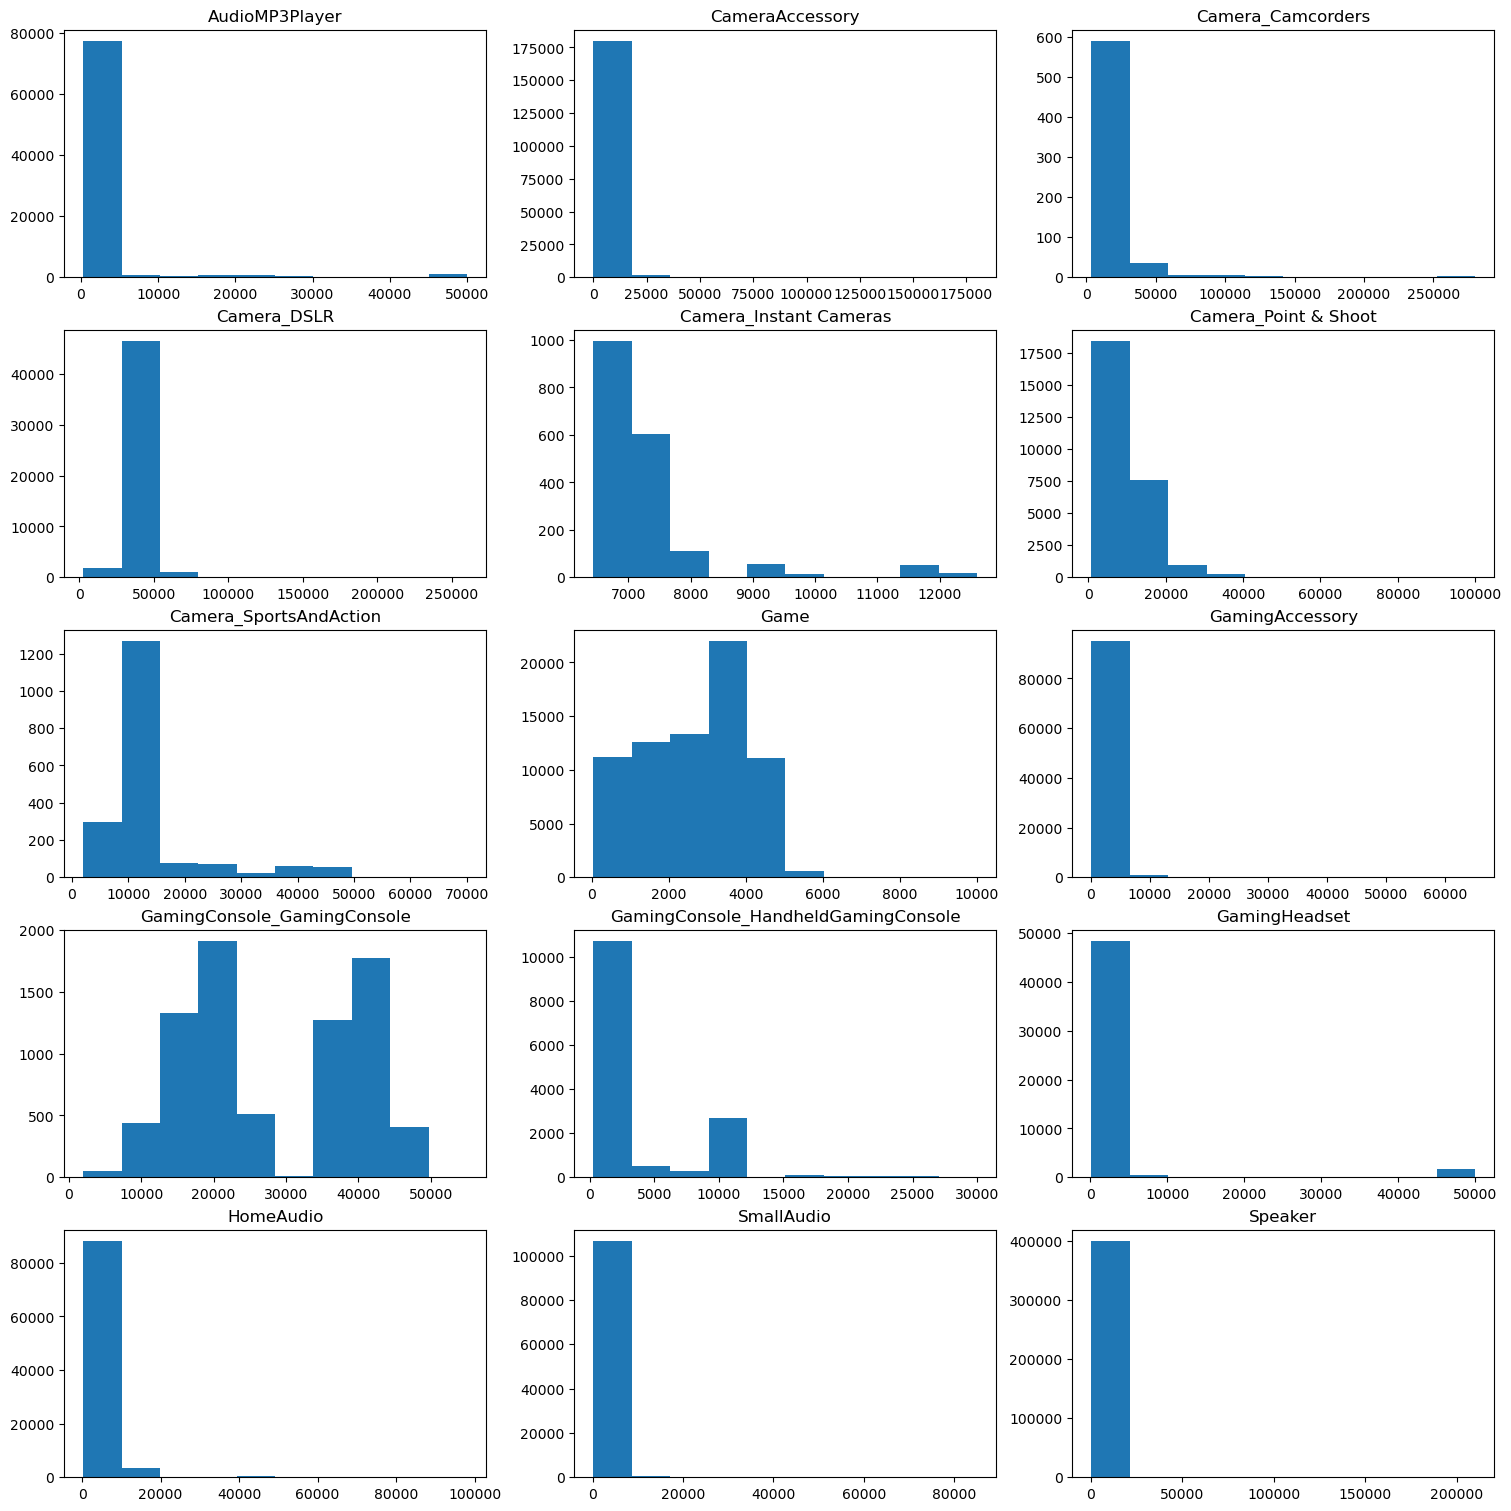

In [58]:
# Visualization of some of the long tails after recategorization.

fig, axs = plt.subplots(5,3,figsize=(15,15),layout='constrained')

grouped = tr.groupby('new_cat')

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key).unit_mrp)
    ax.set_title(f'{key}')


In [7]:
# First ensure that MRP is counted per unit.
# It was not explicitly defined if the MRP is on group or per unit. 
# This has been justified that dividing it will bring the distribution to be reduce outliers
# And that the outliers do not consist a huge part of the population.

tr['unit_mrp']=tr.product_mrp/tr.units
tr.groupby('units').unit_mrp.count().head(10)

units
1     1164941
2       13901
3        1605
4         611
5         626
6         135
7          39
8          48
9          26
10        175
Name: unit_mrp, dtype: int64

With some of the transformations, we can see below that they behave more nicely. They look to behave to have something that we can model.

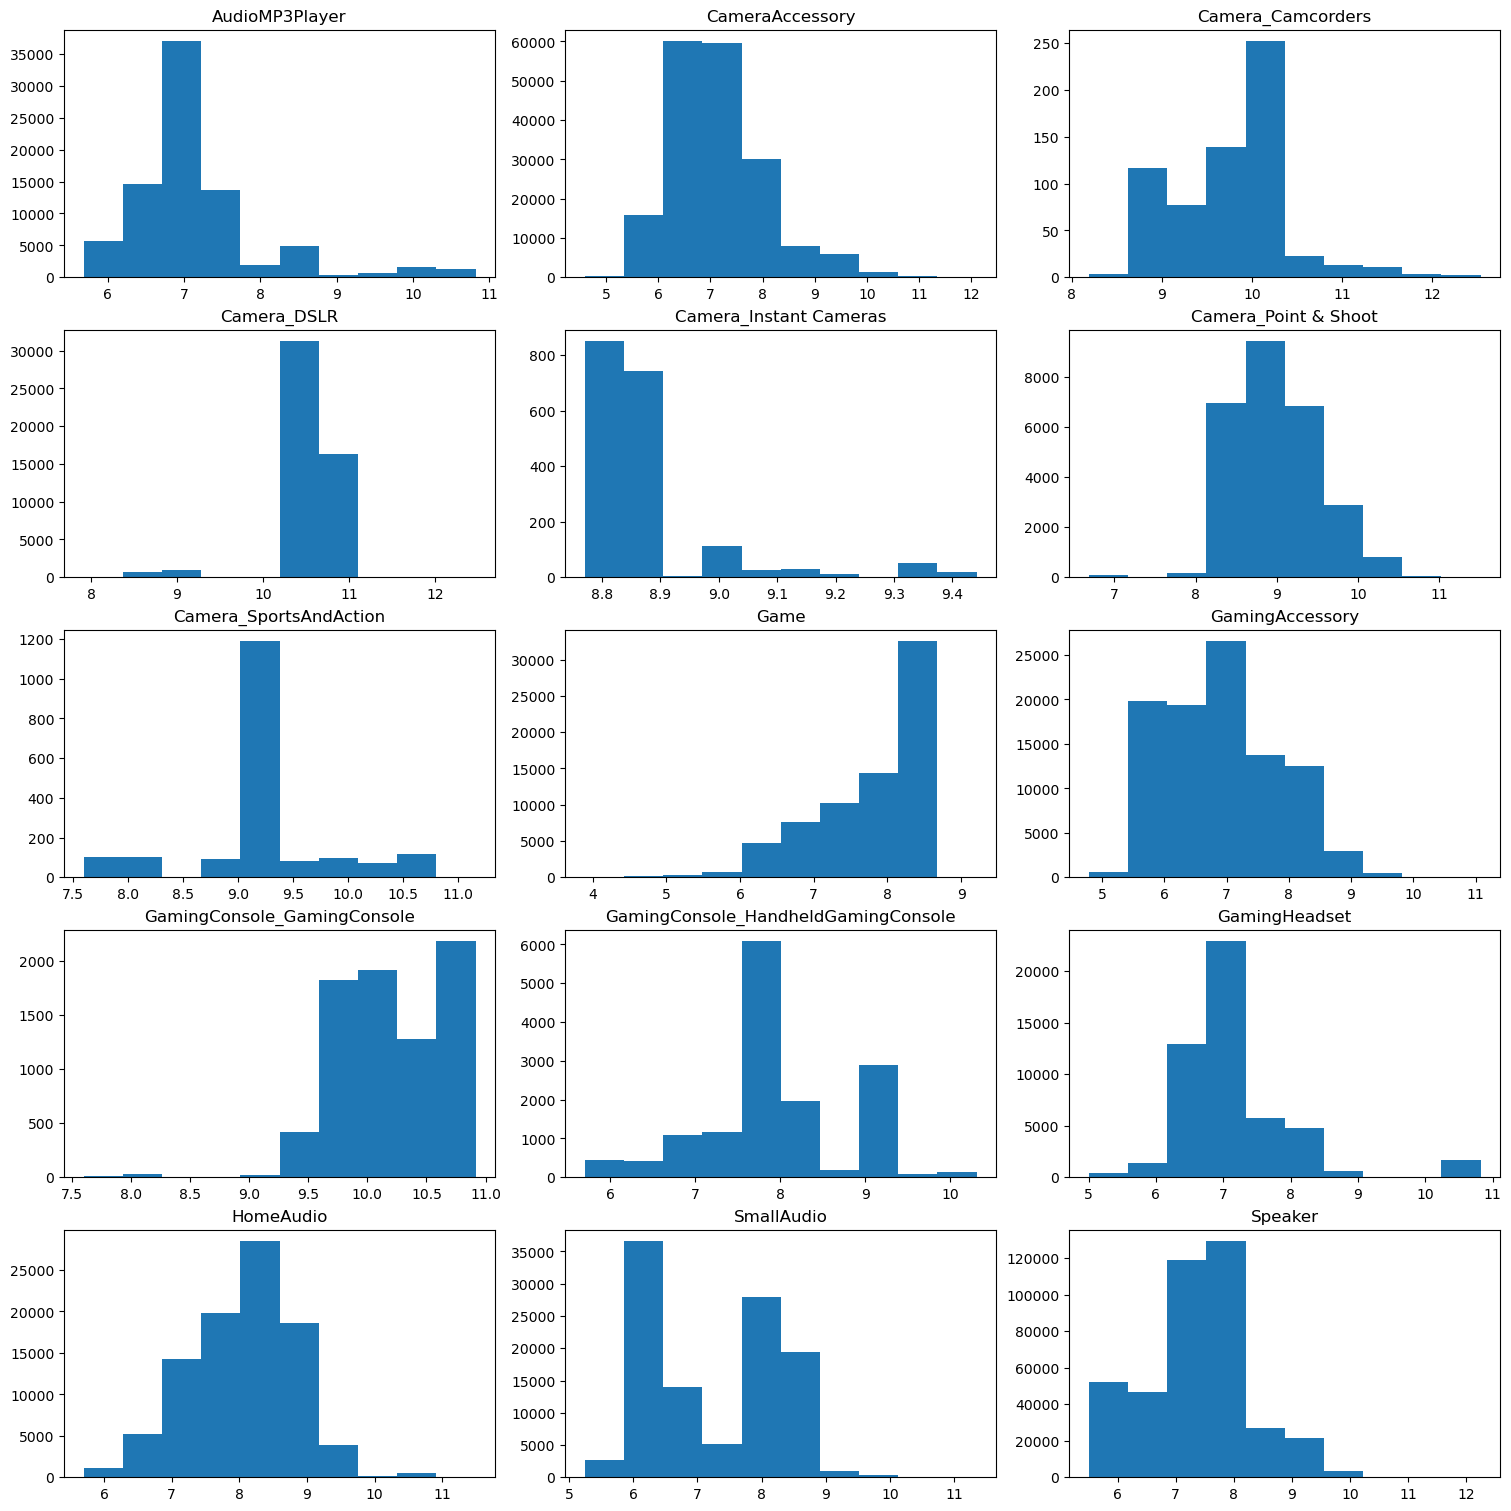

In [8]:
tr['log_unit_mrp'] = np.log(tr['unit_mrp'])
tr['discount_val_r'] = 1 - (tr.discount/tr.product_mrp)
tr['log_gmv']=np.log(tr.gmv_new)
tr['log_d']=np.log(tr.discount_val_r)

fig, axs = plt.subplots(5,3,figsize=(15,15),layout='constrained')

grouped = tr.groupby('new_cat')

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key).log_unit_mrp)
    ax.set_title(f'{key}')


# Visualization of some of the distributions after transformation. These behave much better. 

Looking at some of the distributions of certain categories, we notice that they could be subdivided a bit further based on pricing as there seems to be some multimodal behaviour. We thus choose a threshold based on both where the modal shift is located to divide the distributions into two roughly Poisson like shapes. For the future, it would probably be better to try to use a Gaussian mixture model to separate the two multimodal components in a more organic way to simulate this.

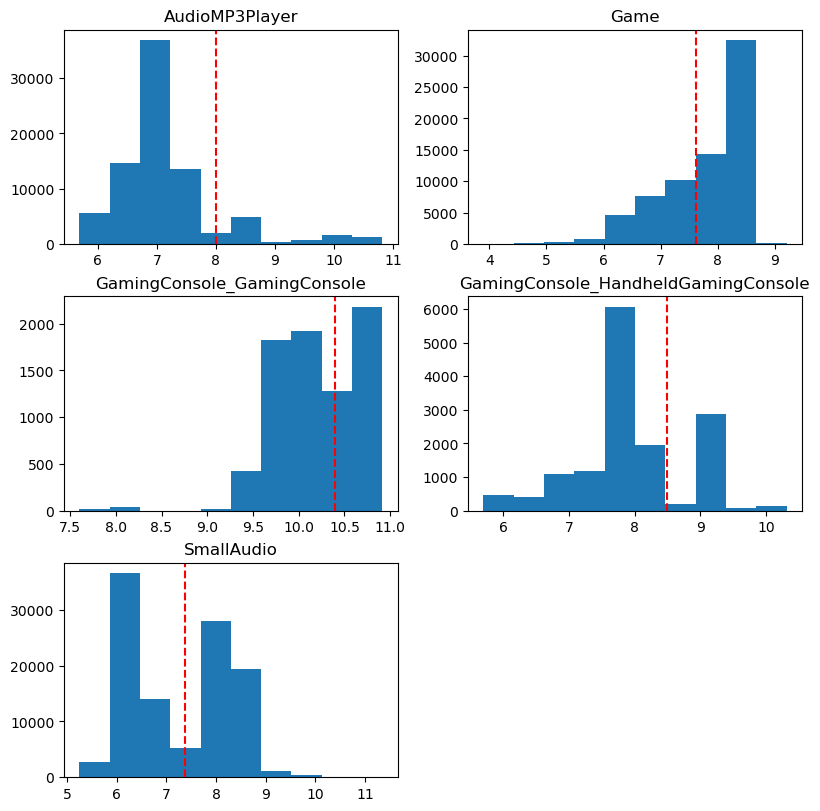

In [11]:
# Plot into 4 graphs, marking the graphs with the certain thresholds. 

threshold_dicts= {
'SmallAudio':7.38,
    'AudioMP3Player':8,
    'Game':7.619,
    'GamingConsole_GamingConsole':10.4,
    'GamingConsole_HandheldGamingConsole':8.5

}


fig, axs = plt.subplots(3,2,figsize=(8,8),layout='constrained')

grouped = tr[tr.new_cat.isin(threshold_dicts.keys())].groupby('new_cat')

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.hist(grouped.get_group(key).log_unit_mrp)
    ax.axvline(threshold_dicts.get(key),ls='--', color='r')
    ax.set_title(f'{key}')

fig.delaxes(axs[2,1])

In [12]:
## Assign the thresholds to split the product categories further

for key, val in threshold_dicts.items():
    tr.loc[(tr.new_cat==key)&(tr.log_unit_mrp>=val),'new_cat'] = f'{key}_Upper'
    tr.loc[(tr.new_cat==key)&(tr.log_unit_mrp<val),'new_cat'] = f'{key}_Lower'


To try to draw conclusions, we will aim to aggregate the figures on a daily level so that the count data is summarized in some sense. We will use the mean for most distributions as by partitioning the categories in a certain way, it is hoped that the mean would represent a fair sample of the distribution. 



In [18]:
ttl_rev = tr.groupby(['Date','MonthStart','is_holiday','is_weekend','new_cat','promos',
            'special_dates']).gmv_new.sum()

ttl_uprice = tr.groupby(['Date','MonthStart','is_holiday','is_weekend','new_cat','promos',
            'special_dates']).log_unit_mrp.mean()

ttl_dmean = tr.groupby(['Date','MonthStart','is_holiday','is_weekend','new_cat','promos',
            'special_dates']).log_d.mean()

ttl_count = tr.groupby(['Date','MonthStart','is_holiday','is_weekend','new_cat','promos',
            'special_dates']).units.count()

In [74]:
flc=pd.concat([ttl_rev,ttl_uprice,ttl_dmean,ttl_count],axis=1).reset_index()
flc['gmv_new'] = np.log(flc.gmv_new)
flc['units'] = np.log(flc['units'] )

In [76]:
# Merge with marketing total spending, but divided by number of dates here. 
flc = flc.merge(secondfile_investment[['Date','Total.Investment']].rename(columns={'Date':'MonthStart'}),how='left',
          on='MonthStart').merge(
    ttl_rev.reset_index().groupby(['MonthStart']).Date.nunique().rename('dcount'),how='left',on='MonthStart')
flc['ttl_investment'] = flc['Total.Investment']/flc.dcount
flc=flc.drop(columns=['MonthStart','Total.Investment','dcount'],axis=1)   

In [78]:
flc.to_csv('../causal_inf_project/cache_flc.csv',index=False)

We will also create another version more granular that attempts to look at general quantiles to capture the distribution space as well for analysis. We cut into 20 bins as a placeholder for both the unit mrp and discount distributions. This will signal how much count is aggregated in a particular area. 

In [ ]:
tr['test_log_unit_mrp_cut'] = tr.groupby('new_cat').log_unit_mrp.transform(lambda x: pd.cut(x,bins=20))
tr['test_log_d_cut'] = tr.groupby('new_cat').log_d.transform(lambda x: pd.cut(x,bins=20))

tr['test_log_unit_mrp_cut'] = tr.test_log_unit_mrp_cut.apply(lambda x: x.mid).astype('float')
tr['test_log_d_cut'] = tr.test_log_d_cut.apply(lambda x: x.mid).astype('float')

In [ ]:
flc_test = tr.groupby(
       ['Date','is_holiday','is_weekend','new_cat','promos',
            'special_dates','test_log_unit_mrp_cut','test_log_d_cut',]
).gmv_new.aggregate(['count','sum']).reset_index()

flc_test = flc_test.rename(columns={'count':'units',
                        'test_log_unit_mrp_cut':'log_unit_mrp',
                        'sum':'gmv_new',
                        'test_log_d_cut':'log_d'})

flc_test['gmv_new'] = np.log(flc_test.gmv_new)

Given that sales cleaned has SLA data which might be useful for understanding NPS, we will aggregate and extract that info as well. Lastly, we will create a version of the data aggregated from firstfile on monthly basis that is more suitable for analysis of monthly level metrics (eg marketing spend/NPS score) given that it is more complete.  Note that we will eliminate those procurement SLA which are more than 15, as this seems like a placeholder for maybe a preorder as most of it comes from games.

In [88]:
sales_cleaned.groupby('Procurement_SLA').MRP.count()

Procurement_SLA
-1        56923
 0        30130
 1       192104
 2       316475
 3       200639
 4        81015
 5       138535
 6        11921
 7         8932
 8          359
 9           56
 10          47
 12          42
 13         343
 14        3247
 15        5717
 1000      2090
Name: MRP, dtype: int64

In [ ]:

def recategorize_sales(row):
    if row['Analytic_Category'] == 'Camera':
        return 'Camera_'+row['product_analytic_vertical']
    elif row['Analytic_Category'] == 'CameraAccessory':
        return 'CameraAccessory'
    elif row['Sub_category'] == 'AudioAccessory' or row['Sub_category']=='TVVideoSmall':
        return 'SmallAudio'
    elif row['product_analytic_vertical'] == 'GamingHeadset':
        return 'GamingHeadset'
    elif row['Sub_category'] in ('GamingAccessory','Game','Speaker','AudioMP3Player'):
        return row['Sub_category']  
    elif row['Sub_category'] == 'GamingConsole':
        return 'GamingConsole_'+row['product_analytic_vertical']
    elif row['Sub_category'] in ('AmplifierReceiver','HomeTheatre','HomeAudio'):
        return 'HomeAudio'


def aggregate_sales_cleaned(df):
    f1 = df[(df.MonthStart>=pd.Timestamp(2015,10,1))
        &(df.MonthStart<=pd.Timestamp(2016,4,1))
        &(df.Sub_category!='GameMembershipCards')
        &(df.Procurement_SLA<=100)
        &(df.new_GMV>0)
        ]

    f1['new_cat']=f1.apply(recategorize_sales,axis=1)

    f1['unit_mrp']=f1.MRP/f1.Units_sold
    f1['log_unit_mrp']=np.log(f1['unit_mrp'])

    for key, val in threshold_dicts.items():
        f1.loc[(f1.new_cat==key)&(f1.log_unit_mrp>=val),'new_cat'] = f'{key}_Upper'
        f1.loc[(f1.new_cat==key)&(f1.log_unit_mrp<val),'new_cat'] = f'{key}_Lower'

    f2 = f1.groupby('MonthStart').SLA.mean().reset_index()
    
    return f2

sla_val = aggregate_sales_cleaned(sales_cleaned)

In [68]:
# Normalizing both counts as well 

sf = secondfile_investment[['dig','traditional','Sponsorship',
                     'Affiliates','Other','Total.Investment',
                    'Date']].merge(tr.groupby(['MonthStart']).Date.nunique().rename('dcount')
                                   ,how='left',left_on='Date',right_on='MonthStart'
                                  )

sf[['dig','traditional','Sponsorship','Affiliates','Other','Total.Investment']] = (
sf[['dig','traditional','Sponsorship','Affiliates','Other','Total.Investment']].div(sf.dcount,axis='rows')
)
sf= sf.drop(['dcount'],axis=1)

In [72]:
ttl_rev_exp = tr.groupby(['MonthStart','new_cat']
            ).gmv_new.sum()/tr.groupby(['MonthStart','new_cat']).Date.nunique()


ttl_rev_exp = (ttl_rev_exp/100000).unstack(level=1)
ttl_rev_exp['y_ttl'] = ttl_rev_exp.sum(axis=1)

ttl_rev_exp = ttl_rev_exp.merge(sf,how='left',
         left_index=True,right_on='Date').merge(
    sla_val,how='left',left_on='Date',right_on='MonthStart'
).merge(npsscore,how='left',on='Date')

In [73]:
ttl_rev_exp.to_csv('../causal_inf_project/month_data.csv')